# Midterm Project 452
## Group members: Dominic Felice

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Data Preprocessing

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values to the range [0, 1]
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

# Flatten the images to create 784-dimensional vectors
train_images = train_images.reshape(-1, 784)
test_images = test_images.reshape(-1, 784)

# Reducing data to 1/5 it's original size while maintaining distrubuition 
X_train, _, y_train, _ = train_test_split(
    train_images, train_labels, test_size=0.8, stratify=train_labels, random_state=42)

X_test, _, y_test, _ = train_test_split(
    test_images, test_labels, test_size=0.8, stratify=test_labels, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (12000, 784)
Testing data shape: (2000, 784)


## Model Implementation

### KNN

#### Training

In [3]:
k_values = range(1, 11)  # Testing k values from 1 to 10
num_repetitions = 10
num_folds = 10
k_scores = {k: [] for k in k_values}

for seed in range(num_repetitions):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
        k_scores[k].append(scores.mean())

#### Testing & Metrics

In [4]:
# Calculate the mean accuracy for each k across all repetitions
avg_k_scores = {k: np.mean(k_scores[k]) for k in k_values}
optimal_k = max(avg_k_scores, key=avg_k_scores.get)

# Evaluate model performance using the optimal k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)
y_pred_knn = knn_optimal.predict(X_test)

# Calculate performance metrics
training_accuracy_knn = knn_optimal.score(X_train, y_train)
test_accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
classification_rep_knn = classification_report(y_test, y_pred_knn)

print(f"Optimal k: {optimal_k}")
print("Performance metrics for Optimal k:")
print(f"  Test Accuracy: {test_accuracy_knn:.4f}")
print(f"  Precision: {precision_knn:.4f}")
print(f"  Recall: {recall_knn:.4f}")
print(f"  F1 Score: {f1_knn:.4f}")

Optimal k: 1
Performance metrics for Optimal k:
  Test Accuracy: 0.9490
  Precision: 0.9496
  Recall: 0.9490
  F1 Score: 0.9490


#### Visualizations

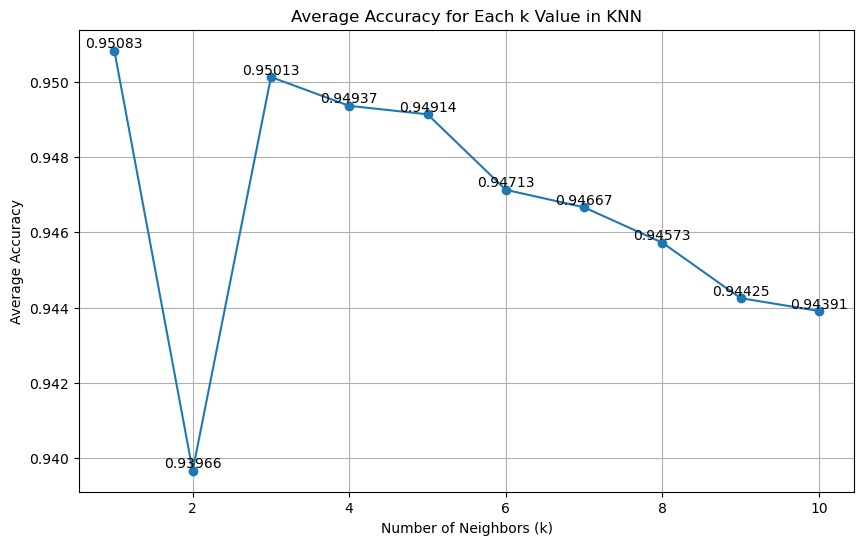

In [5]:
plt.figure(figsize=(10, 6))
k_values_list = list(avg_k_scores.keys())
avg_accuracies = list(avg_k_scores.values())

# Plot line and markers
plt.plot(k_values_list, avg_accuracies, marker='o', label='Average Accuracy')

# Adding accuracy points
for i, k in enumerate(k_values_list):
    plt.text(k, avg_accuracies[i], f"{avg_accuracies[i]:.5f}", ha='center', va='bottom')

# Labels and title
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for Each k Value in KNN')
plt.grid(True)
plt.show()

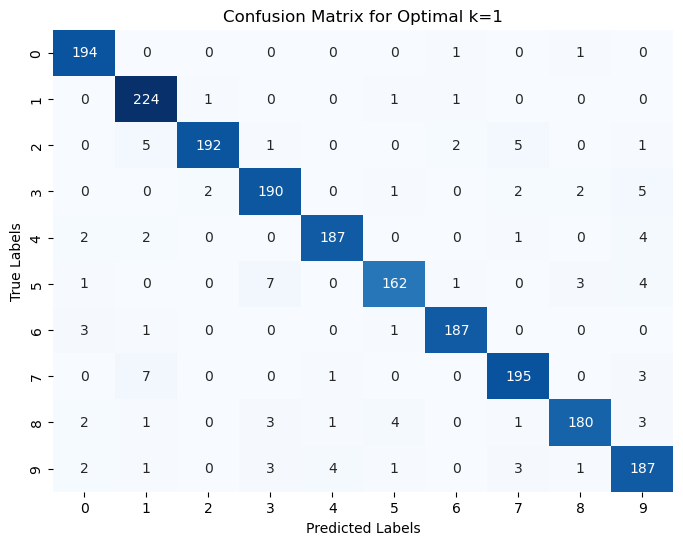

In [6]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix for Optimal k={optimal_k}')
plt.show()

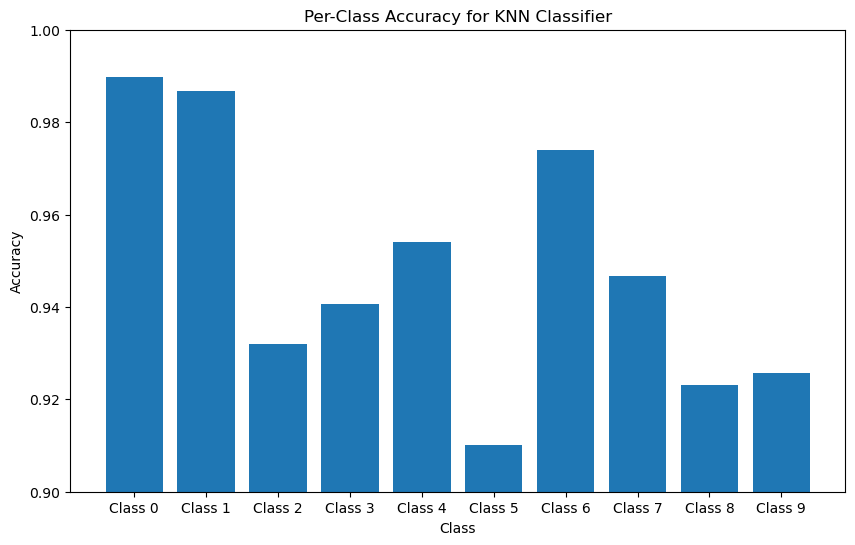

In [7]:
per_class_accuracy = conf_matrix_knn.diagonal() / conf_matrix_knn.sum(axis=1)

# Visualize per-class accuracy
plt.figure(figsize=(10, 6))
classes = [f"Class {i}" for i in range(len(per_class_accuracy))]
plt.bar(classes, per_class_accuracy)
plt.ylim(.9, 1)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy for KNN Classifier")
plt.show()

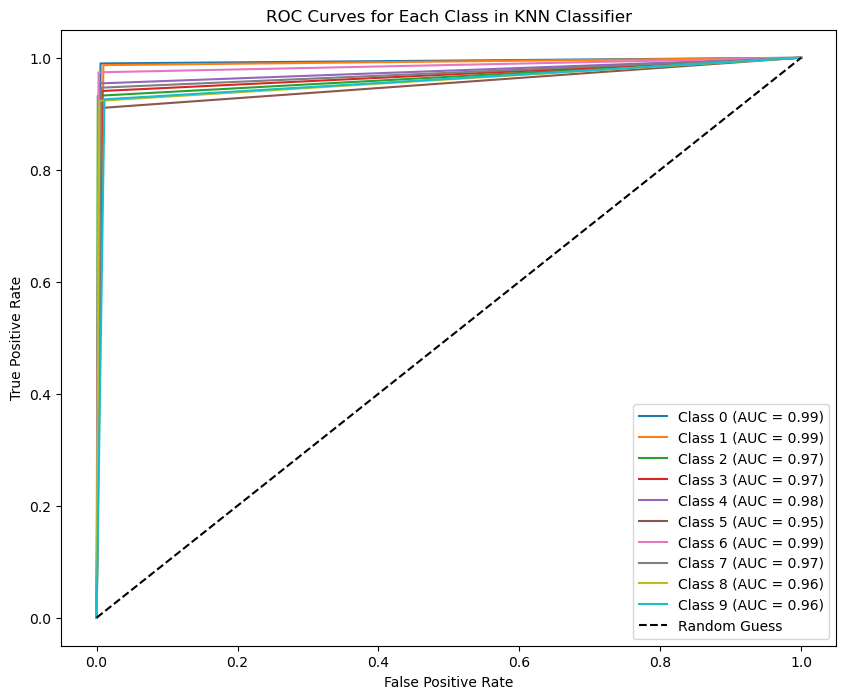

In [8]:
num_classes = len(np.unique(y_test))  # Number of unique classes in y_val
y_val_binarized = label_binarize(y_test, classes=range(num_classes))
y_pred_knn_binarized = label_binarize(y_pred_knn, classes=range(num_classes))

# Plotting ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_pred_knn_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class in KNN Classifier")
plt.legend(loc="best")
plt.show()

### Logtistic Regression

#### Training

In [9]:
param_grid_lg = [
    {'C': [.05, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']},
    {'penalty': [None], 'solver': ['lbfgs']}
]

# Grid search with cv for LogReg
grid_search_lg = GridSearchCV(LogisticRegression(max_iter=500), param_grid_lg, cv=5, scoring='accuracy')
grid_search_lg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500),
             param_grid=[{'C': [0.05, 0.1, 1, 10], 'penalty': ['l2'],
                          'solver': ['lbfgs']},
                         {'penalty': [None], 'solver': ['lbfgs']}],
             scoring='accuracy')

#### Testing & Metrics

In [10]:
# Best settings & Accuracy
best_params_lg = grid_search_lg.best_params_
best_accuracy_lg = grid_search_lg.best_score_

print("Best Parameters:", best_params_lg)
print("Best Cross-Validated Accuracy:", best_accuracy_lg)

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validated Accuracy: 0.9067500000000001


In [11]:
best_log_reg = grid_search_lg.best_estimator_
y_pred_lg = best_log_reg.predict(X_test)

# Calculate performance metrics
accuracy_lg = accuracy_score(y_test, y_pred_lg)
precision_lg = precision_score(y_test, y_pred_lg, average='weighted')
recall_lg = recall_score(y_test, y_pred_lg, average='weighted')
f1_lg = f1_score(y_test, y_pred_lg, average='weighted')
conf_matrix_lg = confusion_matrix(y_test, y_pred_lg)
iterations_lg = best_log_reg.n_iter_.max()

print(f"Logistic Regression Performance Metrics:")
print(f"  Test Accuracy: {accuracy_lg:.4f}")
print(f"  Precision: {precision_lg:.4f}")
print(f"  Recall: {recall_lg:.4f}")
print(f"  F1 Score: {f1_lg:.4f}")
print(f"  Number of Iterations for Convergence: {iterations_lg}")

Logistic Regression Performance Metrics:
  Test Accuracy: 0.9170
  Precision: 0.9170
  Recall: 0.9170
  F1 Score: 0.9167
  Number of Iterations for Convergence: 107


#### Visualizations

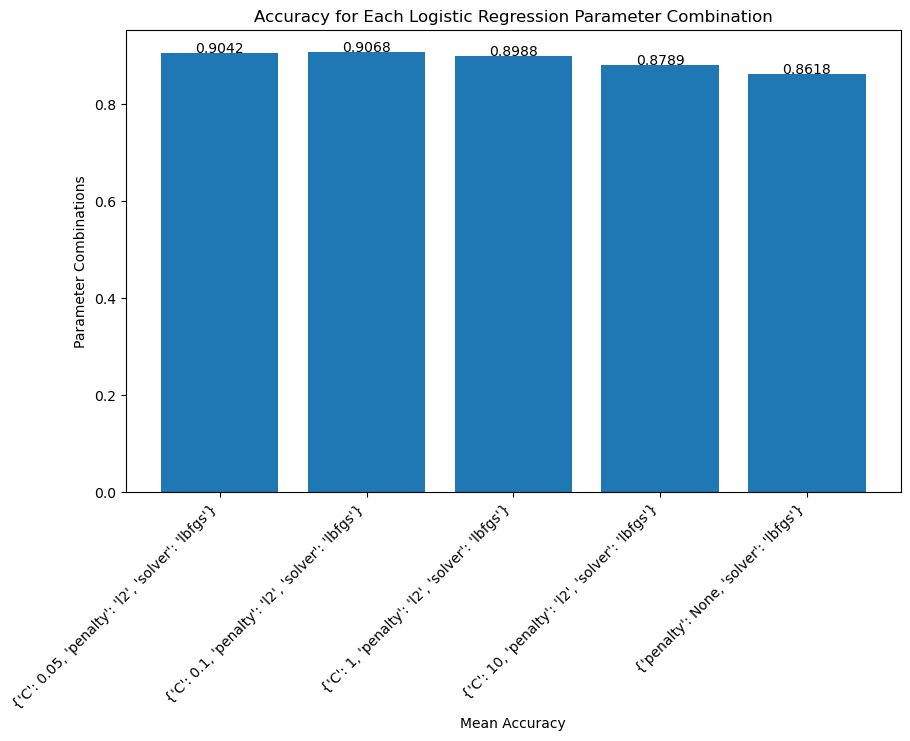

In [40]:
results_lg = grid_search_lg.cv_results_
mean_scores_lg = results_lg['mean_test_score']
params_lg = [str(p) for p in results_lg['params']]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(params_lg, mean_scores_lg)
plt.xlabel('Mean Accuracy')
plt.ylabel('Parameter Combinations')
plt.title('Accuracy for Each Logistic Regression Parameter Combination')
plt.xticks(rotation=45, ha='right')

# Add accuracy scores at the top of each bar
for bar, score in zip(bars, mean_scores_lg):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, f'{score:.4f}', ha='center')

plt.show()

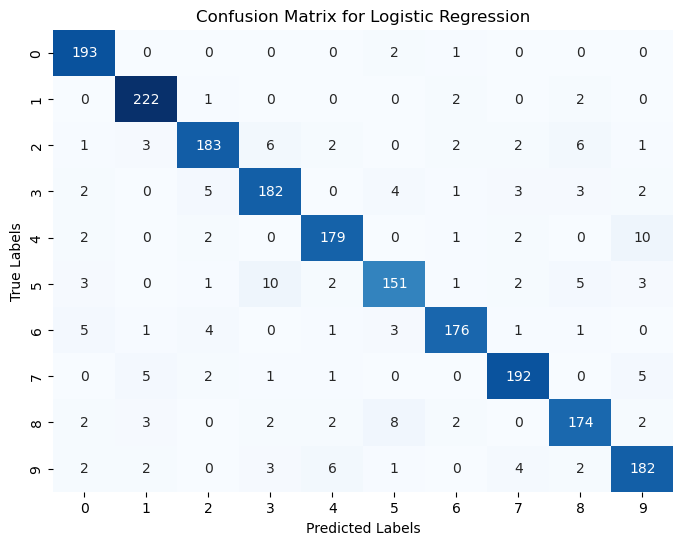

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lg, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

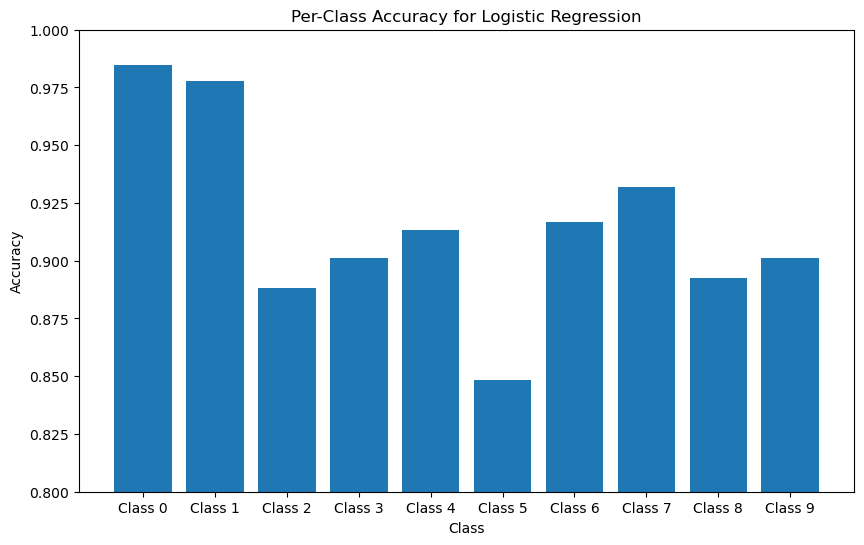

In [14]:
per_class_accuracy_lg = conf_matrix_lg.diagonal() / conf_matrix_lg.sum(axis=1)

plt.figure(figsize=(10, 6))
classes = [f"Class {i}" for i in range(len(per_class_accuracy_lg))]
plt.bar(classes, per_class_accuracy_lg)
plt.ylim(.8, 1)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy for Logistic Regression")
plt.show()

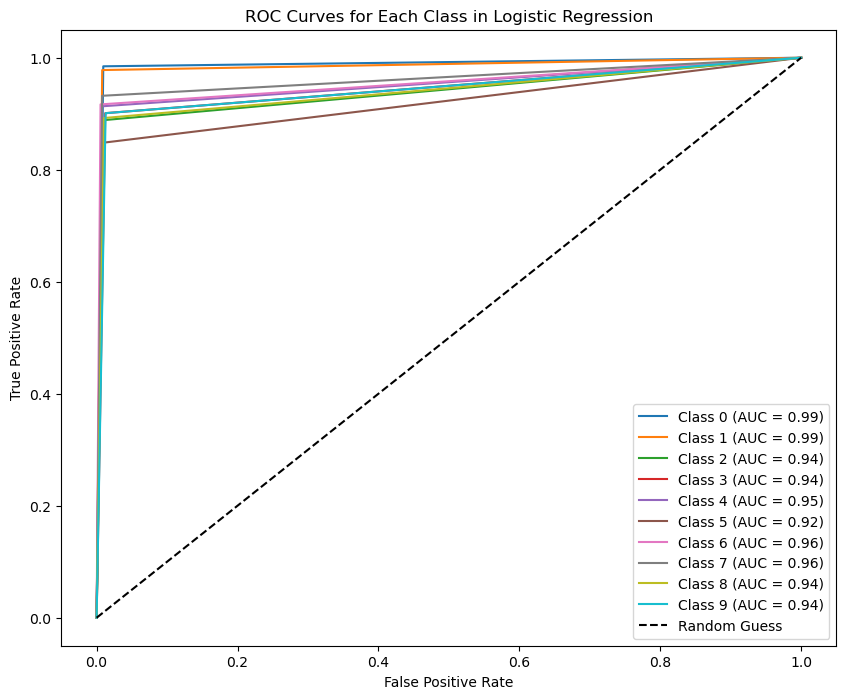

In [15]:
y_val_binarized = label_binarize(y_test, classes=range(len(per_class_accuracy_lg)))  # Binarize y_val
y_pred_lg_binarized = label_binarize(y_pred_lg, classes=range(len(per_class_accuracy_lg)))  # Binarize y_pred_lg

plt.figure(figsize=(10, 8))
for i in range(len(per_class_accuracy_lg)):
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_pred_lg_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class in Logistic Regression")
plt.legend(loc="best")
plt.show()

### SVM

#### Training

In [16]:
param_grid_svm = {
    'kernel': ['poly', 'rbf', 'linear'],
    'C': [0.1, 1, 10]
}

svm = SVC()

# Gridsearch with cv for SVM
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['poly', 'rbf', 'linear']},
             scoring='accuracy')

#### Testing & Metrics

In [17]:
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

best_params_svm, best_score_svm

({'C': 10, 'kernel': 'rbf'}, 0.9670833333333333)

In [18]:
y_pred_svm = grid_search_svm.predict(X_test)

# Calculate performance metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print(f"SVM Performance Metrics for Best Parameters (Kernel = '{best_params_svm['kernel']}', C = {best_params_svm['C']}):")
print(f"  Test Accuracy: {accuracy_svm:.4f}")
print(f"  Precision: {precision_svm:.4f}")
print(f"  Recall: {recall_svm:.4f}")
print(f"  F1 Score: {f1_svm:.4f}")

SVM Performance Metrics for Best Parameters (Kernel = 'rbf', C = 10):
  Test Accuracy: 0.9680
  Precision: 0.9681
  Recall: 0.9680
  F1 Score: 0.9680


#### Visualizations

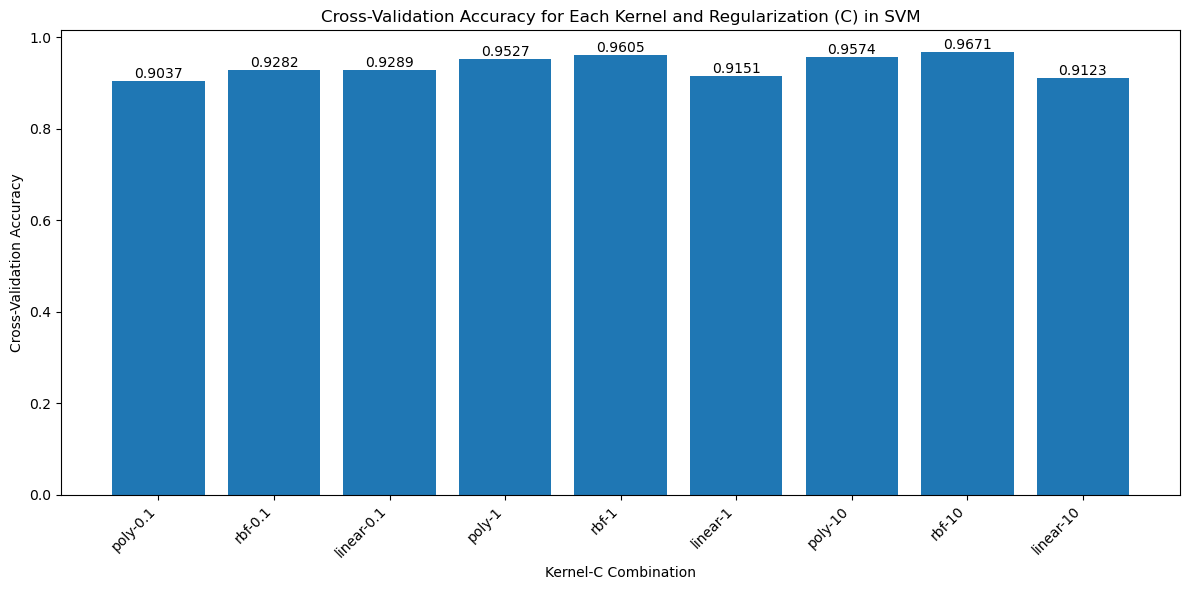

In [19]:
kernel_C_combinations = [f"{param['kernel']}-{param['C']}" for param in grid_search_svm.cv_results_['params']]
accuracies = grid_search_svm.cv_results_['mean_test_score']

# Create bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(kernel_C_combinations, accuracies)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Kernel-C Combination")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Cross-Validation Accuracy for Each Kernel and Regularization (C) in SVM")

# Annotate each bar with its accuracy
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{acc:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

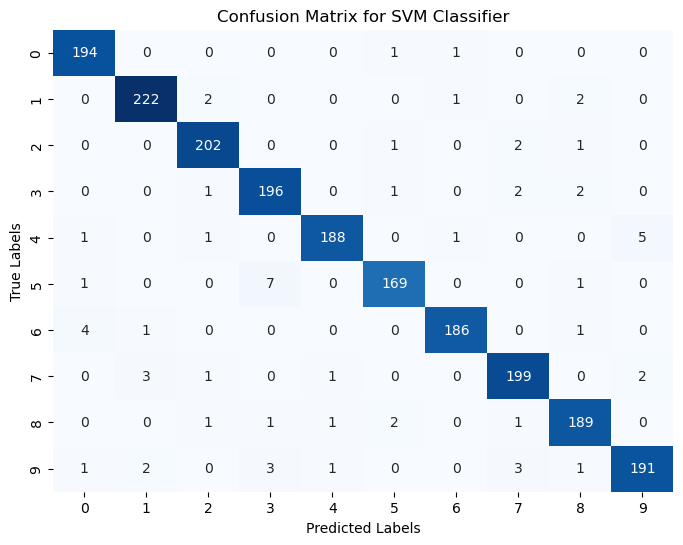

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM Classifier')
plt.show()

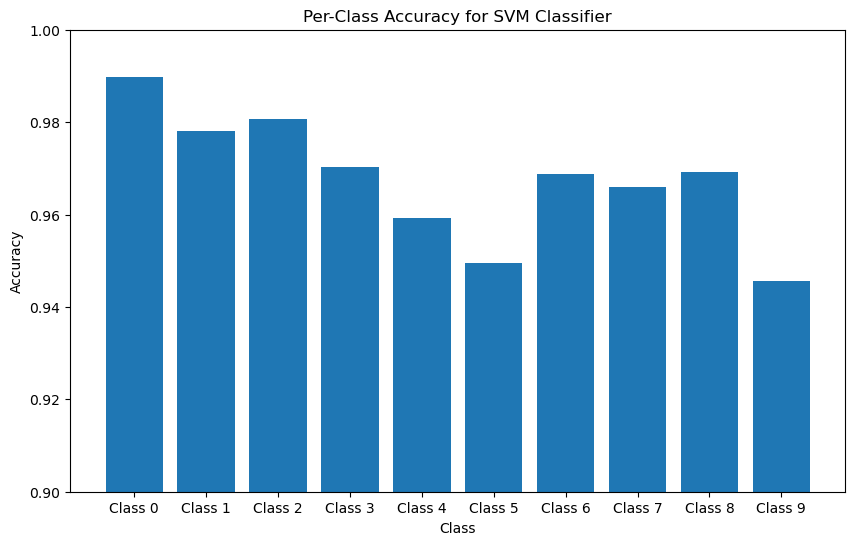

In [21]:
per_class_accuracy_svm = conf_matrix_svm.diagonal() / conf_matrix_svm.sum(axis=1)

plt.figure(figsize=(10, 6))
classes = [f"Class {i}" for i in range(len(per_class_accuracy_svm))]
plt.bar(classes, per_class_accuracy_svm)
plt.ylim(.9, 1)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy for SVM Classifier")
plt.show()

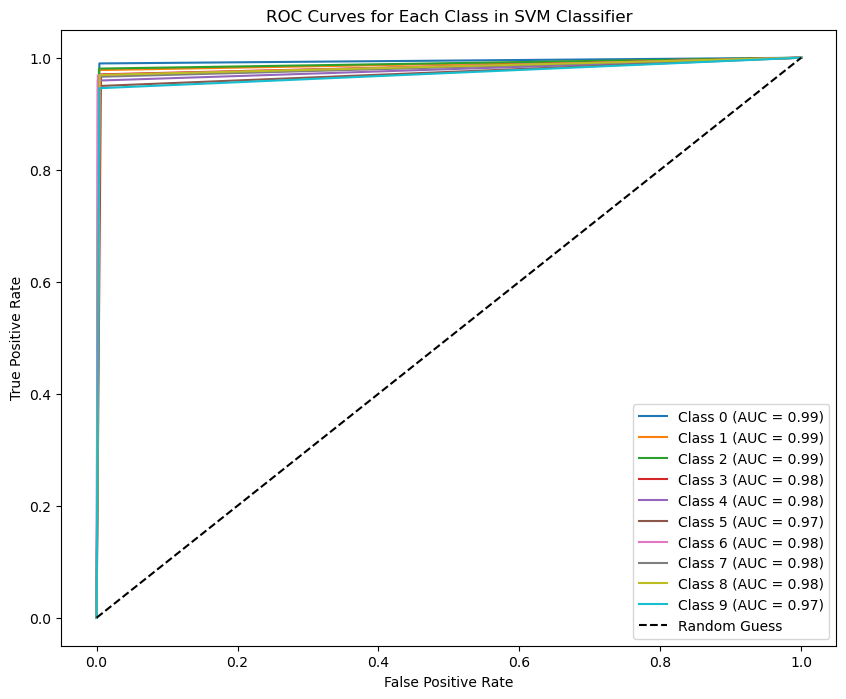

In [22]:
y_val_binarized = label_binarize(y_test, classes=range(len(per_class_accuracy_svm)))  # Binarize y_val
y_pred_svm_binarized = label_binarize(y_pred_svm, classes=range(len(per_class_accuracy_svm)))  # Binarize y_pred_svm

plt.figure(figsize=(10, 8))
for i in range(len(per_class_accuracy_svm)):
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_pred_svm_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class in SVM Classifier")
plt.legend(loc="best")
plt.show()

### Comparisons

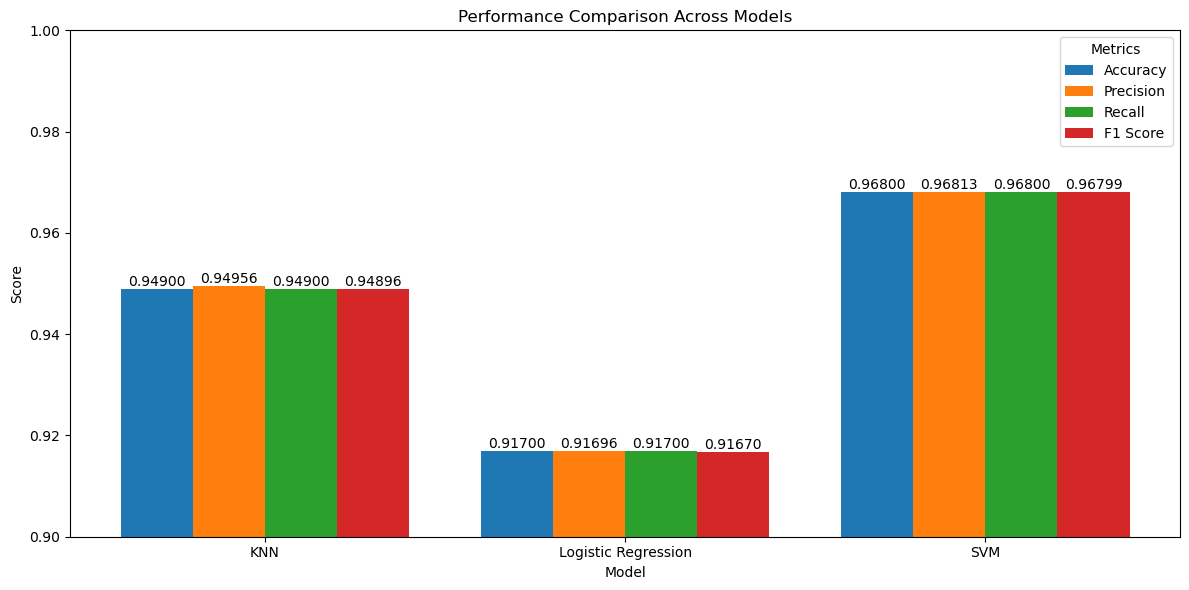

In [23]:
# Assuming we have the performance metrics from different models: KNN, Logistic Regression, and SVM

# Placeholder metrics for demonstration purposes
model_metrics = {
    "KNN": {
        "Accuracy": test_accuracy_knn,
        "Precision": precision_knn,
        "Recall": recall_knn,
        "F1 Score": f1_knn
    },
    "Logistic Regression": {
        "Accuracy": accuracy_lg,
        "Precision": precision_lg,
        "Recall": recall_lg,
        "F1 Score": f1_lg
    },
    "SVM": {
        "Accuracy": accuracy_svm,
        "Precision": precision_svm,
        "Recall": recall_svm,
        "F1 Score": f1_svm
    }
}

# Preparing data for the bar chart
models = list(model_metrics.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = {metric: [model_metrics[model][metric] for model in models] for metric in metrics}

# Plotting the bar chart
x = range(len(models))  # Positions for each model
bar_width = 0.2

plt.figure(figsize=(12, 6))

# Create bars for each metric with text annotations
for i, metric in enumerate(metrics):
    bars = plt.bar([pos + i * bar_width for pos in x], values[metric], width=bar_width, label=metric)
    # Annotate each bar with the metric value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.5f}", ha='center', va='bottom')

# Labeling
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison Across Models")
plt.xticks([pos + bar_width * 1.5 for pos in x], models)
plt.ylim(.9, 1)
plt.legend(title="Metrics")

# Display plot
plt.tight_layout()
plt.show()


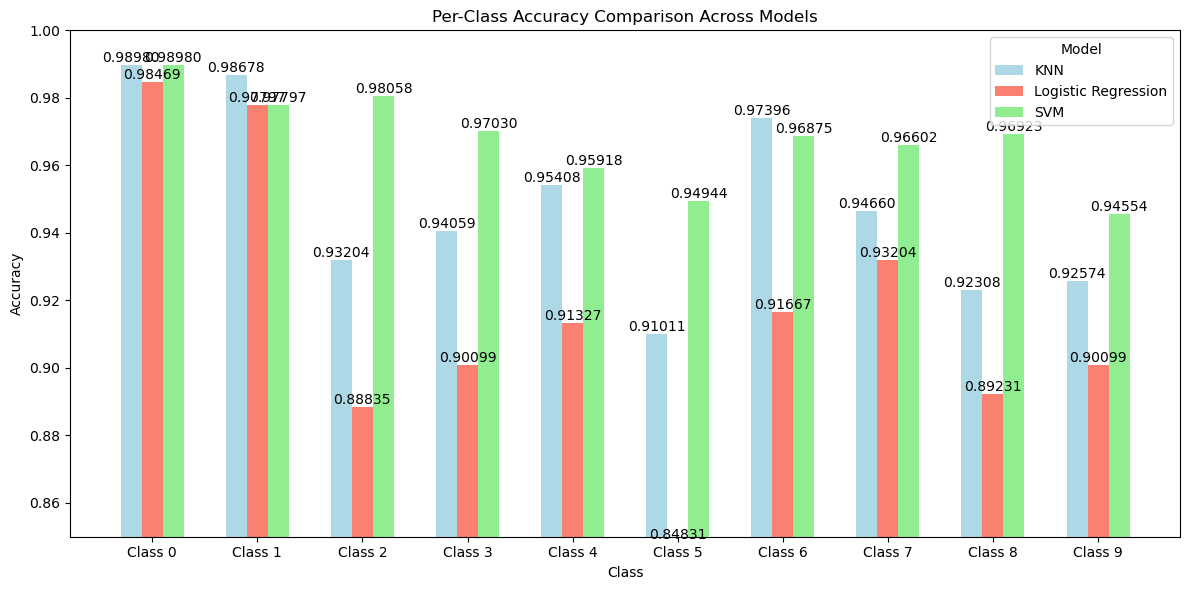

In [24]:
# Prepare data for bar chart with separate bars for each model
classes = [f"Class {i}" for i in range(len(per_class_accuracy))]
x = np.arange(len(classes))  # the label locations
bar_width = 0.2  # width of each bar

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, per_class_accuracy, width=bar_width, label='KNN', color='lightblue')
plt.bar(x, per_class_accuracy_lg, width=bar_width, label='Logistic Regression', color='salmon')
plt.bar(x + bar_width, per_class_accuracy_svm, width=bar_width, label='SVM', color='lightgreen')

# Labeling and annotations
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy Comparison Across Models")
plt.xticks(x, classes)
plt.ylim(.85, 1)
plt.legend(title="Model")

# Annotate each bar with the accuracy value
for i in range(len(classes)):
    plt.text(x[i] - bar_width, per_class_accuracy[i], f"{per_class_accuracy[i]:.5f}", ha='center', va='bottom')
    plt.text(x[i], per_class_accuracy_lg[i], f"{per_class_accuracy_lg[i]:.5f}", ha='center', va='bottom')
    plt.text(x[i] + bar_width, per_class_accuracy_svm[i], f"{per_class_accuracy_svm[i]:.5f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


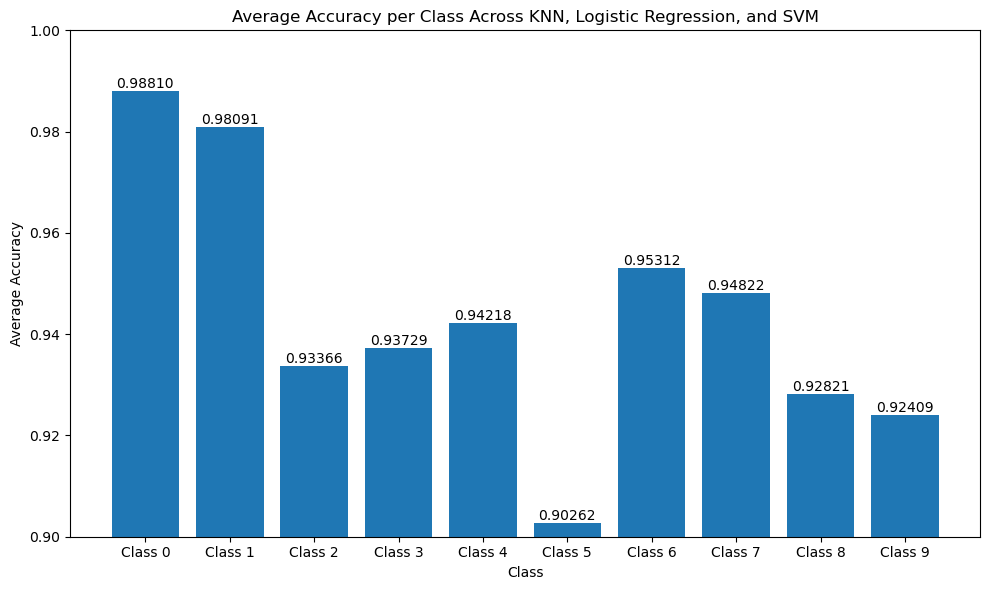

In [25]:
average_class_accuracy = np.mean([per_class_accuracy, per_class_accuracy_lg, per_class_accuracy_svm], axis=0)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
classes = [f"Class {i}" for i in range(len(average_class_accuracy))]
plt.bar(classes, average_class_accuracy)
plt.xlabel("Class")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy per Class Across KNN, Logistic Regression, and SVM")
plt.ylim(.9, 1)

# Annotate each bar with the average accuracy
for i, acc in enumerate(average_class_accuracy):
    plt.text(i, acc, f"{acc:.5f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

### K-Means Clustering

#### Non-PCA

##### Training

In [26]:
# No PCA K-Means
wcss_np = []
for k in range(1, 16):
    kmeans_np = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans_np.fit(X_train)
    wcss_np.append(kmeans_np.inertia_)

##### Visualizations

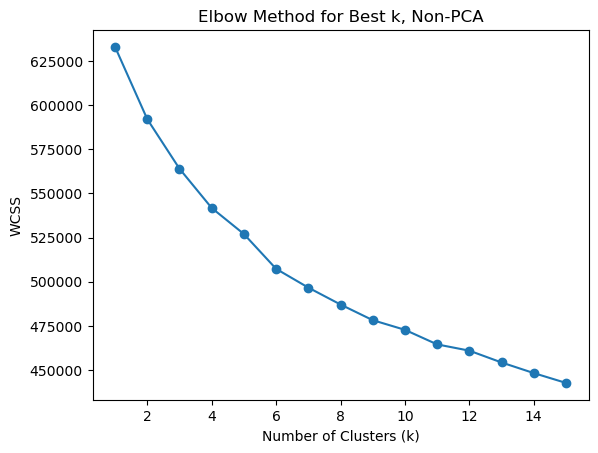

In [27]:
plt.plot(range(1, 16), wcss_np, marker='o')
plt.title("Elbow Method for Best k, Non-PCA")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()

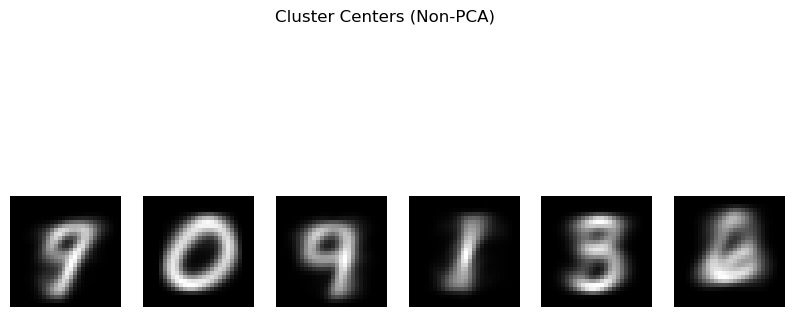

In [28]:
best_k_np = 6
kmeans_np = KMeans(n_clusters=best_k_np, random_state=0, n_init='auto')
kmeans_np.fit(X_train)

# Retrieve the cluster centers and reshape them back to 28x28 images for visualization
cluster_centers_np = kmeans_np.cluster_centers_.reshape(best_k_np, 28, 28)

# Visualize the cluster centers
fig, axes = plt.subplots(1, best_k_np, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cluster_centers_np[i], cmap="gray")
    ax.axis("off")
plt.suptitle("Cluster Centers (Non-PCA)")
plt.show()

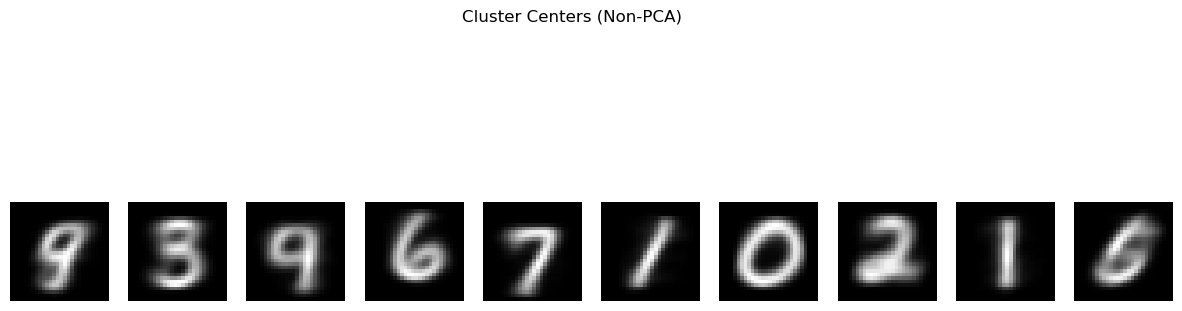

In [29]:
kmeans_np = KMeans(n_clusters=10, random_state=0, n_init='auto')
kmeans_np.fit(X_train)

# Retrieve the cluster centers and reshape them back to 28x28 images for visualization
cluster_centers = kmeans_np.cluster_centers_.reshape(10, 28, 28)

# Visualize the cluster centers
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cluster_centers[i], cmap="gray")
    ax.axis("off")
plt.suptitle("Cluster Centers (Non-PCA)")
plt.show()

#### PCA

##### Training

In [38]:
#PCA K-Means
n_components = 5
pca = PCA(n_components=n_components)
train_images_pca = pca.fit_transform(X_train)
wcss_pca = []
for k in range(1, 16):
    kmeans_pca = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans_pca.fit(train_images_pca)
    wcss_pca.append(kmeans_pca.inertia_)

##### Visualizations

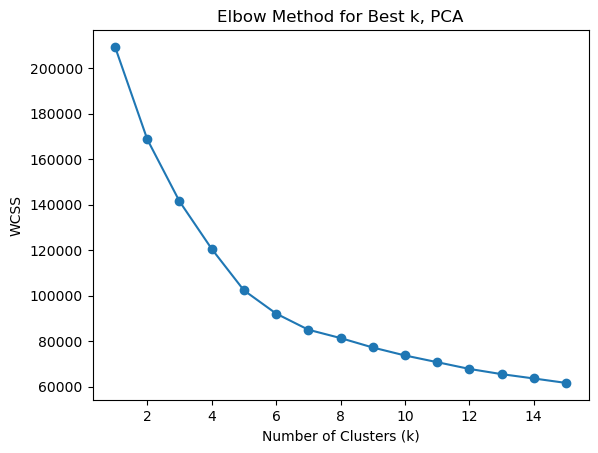

In [39]:
plt.plot(range(1, 16), wcss_pca, marker='o')
plt.title("Elbow Method for Best k, PCA")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()

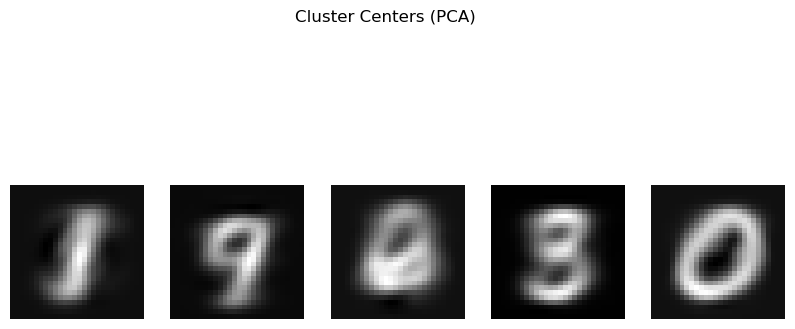

In [32]:
best_k_pca = 5
kmeans_pca = KMeans(n_clusters=best_k_pca, random_state=0, n_init='auto')
kmeans_pca.fit(train_images_pca)

# Inverse transform the cluster centers to the original space
cluster_centers_pca = pca.inverse_transform(kmeans_pca.cluster_centers_)

# Reshape the cluster centers to 28x28 for visualization
cluster_centers_images = cluster_centers_pca.reshape(best_k_pca, 28, 28)

# Visualize the cluster centers
fig, axes = plt.subplots(1, best_k_pca, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cluster_centers_images[i], cmap="gray")
    ax.axis("off")
plt.suptitle("Cluster Centers (PCA)")
plt.show()


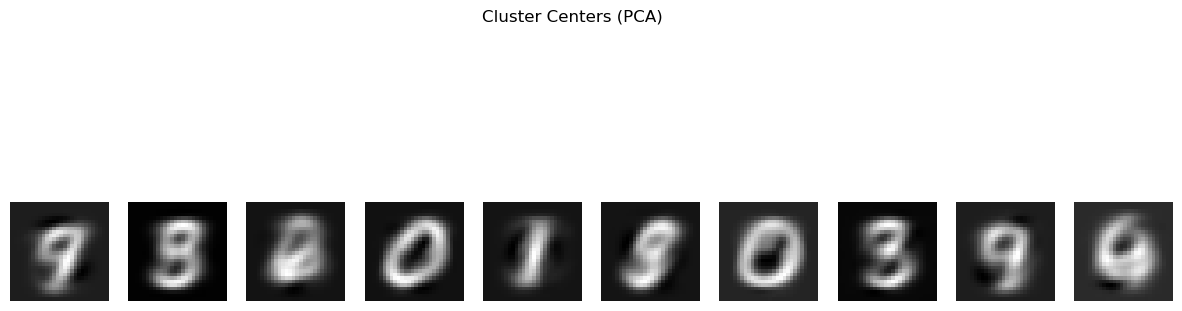

In [33]:
kmeans_pca = KMeans(n_clusters=10, random_state=0, n_init='auto')
kmeans_pca.fit(train_images_pca)

# Retrieve the cluster centers in the PCA-reduced space and inverse-transform them
cluster_centers_pca = pca.inverse_transform(kmeans_pca.cluster_centers_)

# Reshape the cluster centers to 28x28 for visualization
cluster_centers_images = cluster_centers_pca.reshape(10, 28, 28)

# Visualize the cluster centers
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cluster_centers_images[i], cmap="gray")
    ax.axis("off")
plt.suptitle("Cluster Centers (PCA)")
plt.show()